# Motion-Corrected Image Reconstruction (MCIR)

This demonstration shows how to obtain a motion surrogate, estimate motion vector fields and carry out a motion-corrected image reconstruction.

This demo is a 'script', i.e. intended to be run step by step in a
Python notebook such as Jupyter. It is organised in 'cells'. Jupyter displays these
cells nicely and allows you to run each cell on its own.

First version: 14th of June 2021
Author: Christoph Kolbitsch

CCP SyneRBI Synergistic Image Reconstruction Framework (SIRF).  
Copyright 2015 - 2021 Rutherford Appleton Laboratory STFC.  
Copyright 2015 - 2021 University College London.  
Copyright 2015 - 2021 Physikalisch-Technische Bundesanstalt.

This is software developed for the Collaborative Computational Project in Synergistic Reconstruction for Biomedical Imaging 
(http://www.ccpsynerbi.ac.uk/).

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [49]:
# Make sure figures appears inline and animations works
%matplotlib notebook

# Setup the working directory for the notebook
import notebook_setup

In [60]:
__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR
from sirf.Utilities import examples_data_path
from sirf_exercises import exercises_data_path


from cil.framework import  AcquisitionGeometry, BlockDataContainer, BlockGeometry
from cil.optimisation.functions import Function, OperatorCompositionFunction, SmoothMixedL21Norm, L1Norm, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox, TotalVariation, LeastSquares, ZeroFunction
from cil.optimisation.operators import GradientOperator, BlockOperator, ZeroOperator, CompositionOperator,LinearOperator
from cil.optimisation.algorithms import PDHG, FISTA, GD
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# import further modules
import os
import numpy as np
import scipy.signal as sp_signal

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [51]:
# Define a function which plots 3D volume(s) in two orthogonal views
def plot_rpe_3d(dat, sl_idx, lbl, ax=None):
    if ax is None:
        fig, ax = plt.subplots(2,len(dat), squeeze=False)
    for ind in range(len(dat)):
        ax[0,ind].imshow(np.rot90(np.abs(dat[ind][:, sl_idx[0], :]), 1))
        ax[0,ind].set_xticks([])
        ax[0,ind].set_yticks([])
        ax[0,ind].set_ylabel('Foot-Head')
        ax[0,ind].set_xlabel('Right-Left')
        ax[0,ind].set_title(lbl[ind])
        
        ax[1,ind].imshow(np.rot90(np.abs(dat[ind][:, :, sl_idx[1]])))
        ax[1,ind].set_xticks([])
        ax[1,ind].set_yticks([])
        ax[1,ind].set_ylabel('Anterior-Posterior')
        ax[1,ind].set_xlabel('Right-Left')
        

In this exercise we are going to use a 3D data set which has been acquired with a Golden Radial Phase Encoding (GRPE) scheme. For more information on this type of k-space sampling, please have a look at the __MR__ notebook `g_non_cartesian_reconstruction.ipynb`.

In [52]:
pname = '/mnt/materials/SIRF/Fully3D/SIRF/'
fname = 'RPE_MotionPhantom_first70rpe.h5'

In [53]:
# Load in the data
acq_data = pMR.AcquisitionData(pname + fname)
acq_data.sort_by_time()

# Here we are cheating a little bit for the moment, because we have pre-processed the file already. 
# If we had not done that and would like to load a raw data file directly from the scanner, we would
# have to do:
# acq_data = pMR.AcquisitionData(pname + fname)
# acq_data = pMR.preprocess_acquisition_data(acq_data)
# acq_data = pMR.set_grpe_trajectory(acq_data)

## Standard (i.e. uncorrected) image reconstruction
First we are going to carry out a standard MR image reconstruction and because we have done lot's of __MR__ notebooks already, we know the drill: calculate coil maps, set-up acquisition model do the reconstruction.

In [54]:
# Calculate coil sensitivity maps
csm = pMR.CoilSensitivityData()
csm.smoothness = 100
csm.calculate(acq_data)

In [55]:
# Set up acquisition model
E = pMR.AcquisitionModel(acqs=acq_data, imgs=csm)
E.set_coil_sensitivity_maps(csm)

# Calculate the inverse
rec_im = E.inverse(acq_data)
im_inv_uncorr = rec_im.as_array()

<IPython.core.display.Javascript object>


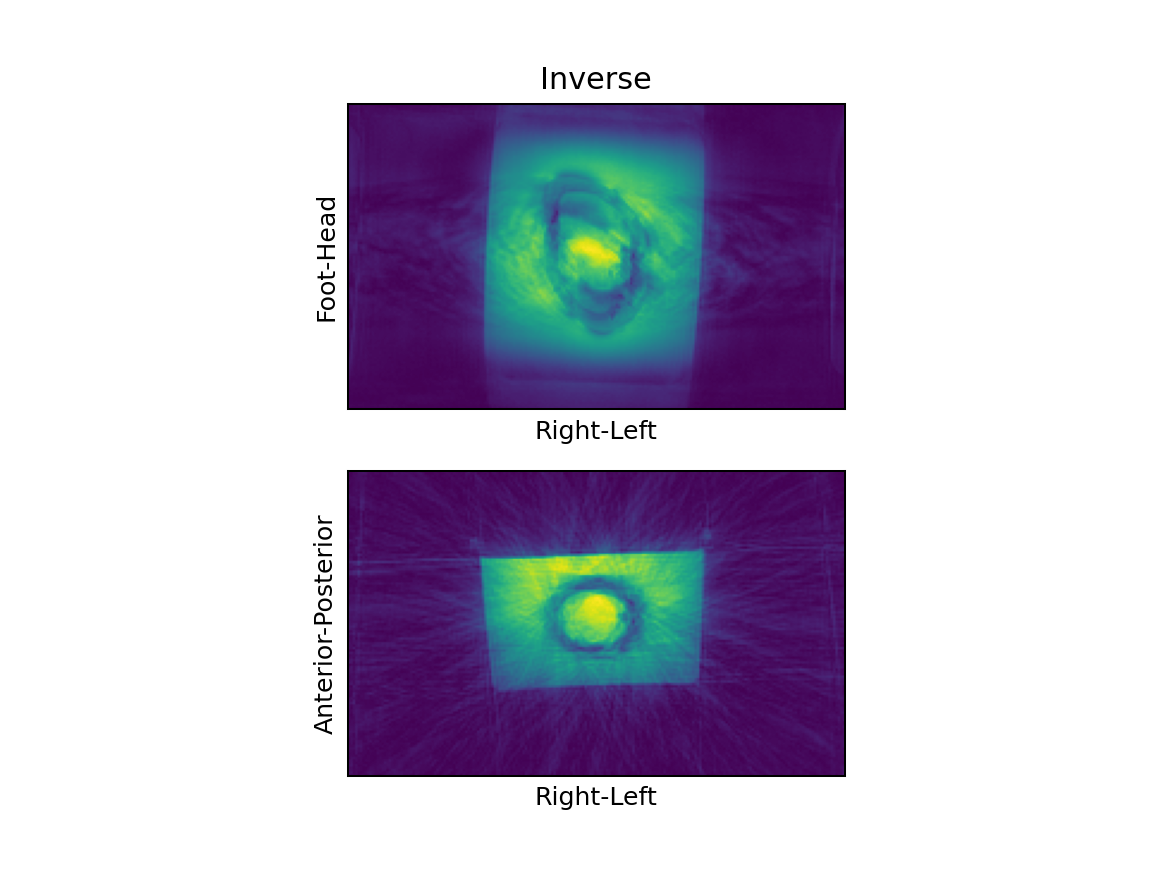

In [56]:
# Visualise result
plot_rpe_3d([im_inv_uncorr,], [64, 64], ['Inverse',])

Well, we have an image but it does not look particularly great. Well, we know that the `inverse` of undersampled data still shows undersampling artefacts, so let's use some iterative reconstruction method and see how we can improve this image. We are going to use _FISTA_ from __CIL__ to do the image reconstruction.

In [57]:
# MR AcquisitionModel
E = pMR.AcquisitionModel(acqs=acq_data, imgs=rec_im)
E.set_coil_sensitivity_maps(csm)

# Starting image
x_init = rec_im.clone()

# Objective function
f = LeastSquares(E, acq_data, c=1)
G = ZeroFunction()

# Set up FISTA for least squares
fista = FISTA(x_init=x_init, f=f, g=G)
fista.max_iteration = 100
fista.update_objective_interval = 5

# Run FISTA
fista.run(20, verbose=True)

# Get the results
im_fista_uncorr = fista.get_output().as_array()

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          5.76885e-02
        5        100         6.907          1.53044e-02
       10        100         6.986          1.35516e-02
       15        100         6.975          1.33335e-02
       20        100         6.982          1.32806e-02
-------------------------------------------------------
       20        100         6.982          1.32806e-02
Stop criterion has been reached.



<IPython.core.display.Javascript object>


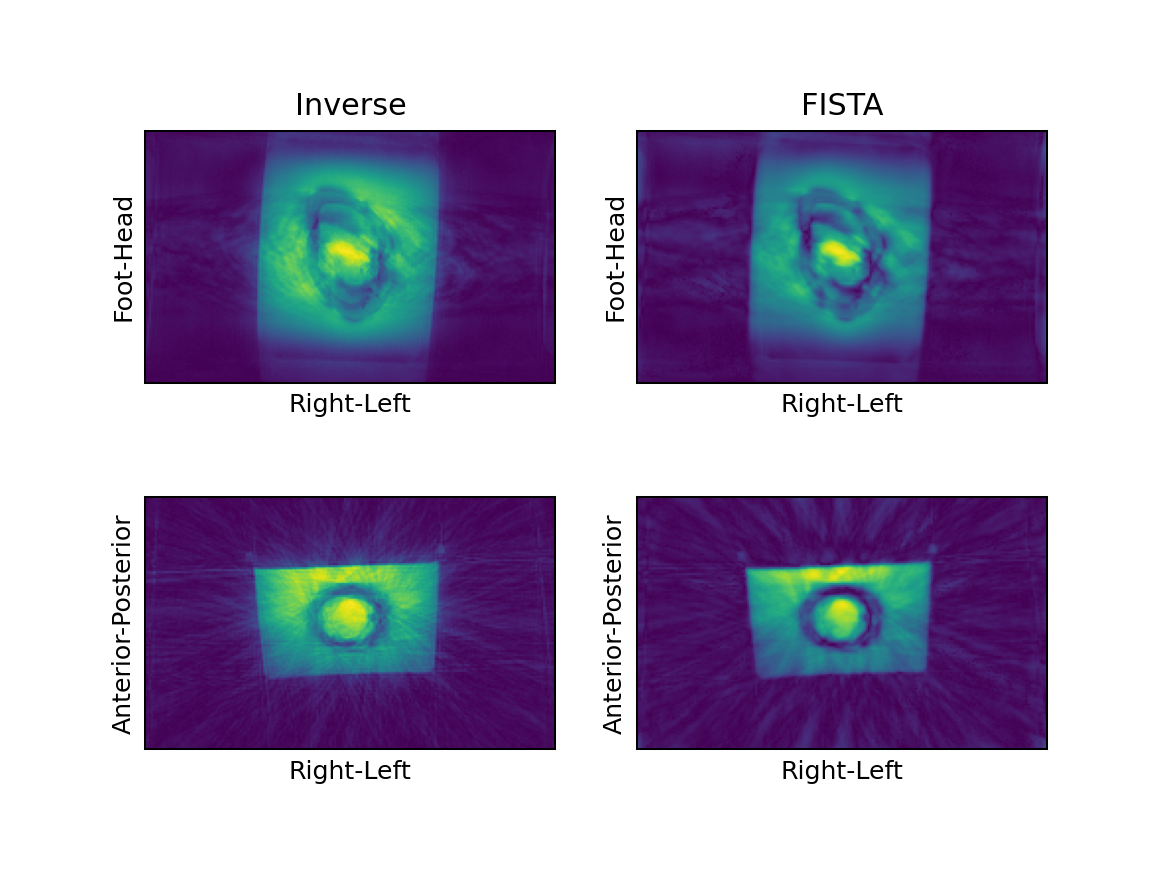

In [59]:
# Visualise result
plot_rpe_3d([im_inv_uncorr, im_fista_uncorr], [64, 64], ['Inverse', 'FISTA'])

Well, again not great. This suggests that the undersampling is not really the problem but (you probably guessed it already from the title of the notebook): 

## Motion

Motion is big topic in MRI, because it can have some unexpected effects, because it leads to a modulation of the acquired k-space. Commonly in imaging we think of motion artefacts mainly as blurring, but in MRI motion artefacts depend of course on the type of motion but also on the k-space sampling and the timing. Motion in MRI can lead to blurring but also ghosting (similar to Cartesian undersampling) or streaking or ....

If you want to know more about motion and its effects in MRI have a look at this paper:

Zaitsev M, Maclaren J, Herbst M. 2015 Motion artifacts in MRI: A complex problem with many partial solutions. J. Magn. Reson. Imaging 42, 887–901. (doi:10.1002/jmri.24850)

Now back to our notebook. What does it mean for your `AcquisitionModel` if there is motion. Before we had for the `forward`:
$$
E x = y_c = \mathcal{F}( C_c \cdot x).
$$
Assuming we have $N_ms$ motion states occuring during our data acquisition and each motion state can be described by a transformation (warp operator) $W_i$ then the above equation can be extended to:
$$
E x = y_c = \sum_i^{N_{ms}}\mathcal{F_i}( C_c \cdot (x \circ W_i)).
$$
This means there is still one image $x$ (which we will call the reference image) without any motion artefacts, this gets then transformed to different motion states by $W_i$ and then the acquired k-space is then the some over all motion states. Note that the Fourier transform has also got an index $i$ because in each motion state different k-space points can be acquired.

## Motion Correction

There are now two basic approaches to reconstruct a motion-corrected image from k-space acquired in different motion states:

### Reconstruct-transform-average (RTA)
Here the idea is to reconstruct an image for each motion state, transform each image to the reference motion state and then average.

### Motion-corrected image reconstruction (MCIR)
For MCIR the encoding operator defined above is used to minimize a least-square-problem to directly reconstruct a motion-corrected image from k-space data acquired in different motion states.

For more details please have a look at:

Brown R et al. 2021 Motion estimation and correction for simultaneous PET/MR using SIRF and CIL. Philos. Trans. R. Soc. A Math. Phys. Eng. Sci. 379, 20200208. (doi:10.1098/rsta.2020.0208)

### What do we need?
For both RTA and MCIR we need 
   * a motion surrogate which tells us which k-space point has been acquired in which motion state
   * motion vector fields ($W_i$) which describe how each voxel moves between the different motion states
    
Lucky for use, _GRPE_ is a sampling scheme which allows to obtain both directly from the motion corrupted scan. 

## Motion surrogate
For _GRPE_ data is acquired along radial lines in the phase encoding plane. This means that the k-space centre is sampled repeatedly. If there is no motion, then the value of the k-space centre should always be the same. Hence, if the value changes between different _RPE_ lines, the change must be related to motion. So we can use the k-space centre to as a so-called self-navigator to find out about the different motion states. We will
   * Find out which k-space points have been acquired at $k_x$ = $k_y$ = $k_z$ = 0
   * Select one coil which shows a good motion signal
   * Use this motion surrogate to calculate which k-space point has been acquired in which motion state

In [66]:
# Get the information about the index of the phase encoding
pe_ky = acq_data.get_ISMRMRD_info('kspace_encode_step_1')

# Find the central value of each GRPE line (i.e. ky=0)
ky_idx = np.where(pe_ky == (np.max(pe_ky)+1)//2)

# Get the k-space as array
acq_data_arr = acq_data.as_array()

# Keep only points which have been acquired in the k-space centre (i.e. ky == 0 & kz == 0)
acq_data_arr = acq_data_arr[ky_idx[0], :, :]

# Select the last coil and the centre of each readout (i.e kx = 0) to get our final 1D motion signal
self_nav = np.abs(np.squeeze(acq_data_arr[:,3,acq_data_arr.shape[2]//2]))

# We said above that the value of the k-space centre should only vary because of motion. 
# This is not entirely true, because it can also vary because of other effects. One is that the spin system
# is in a transient steady state at the beginning of the data acquisition. 
# Therefore, we will simply overwrite the first entry in our motion signal
self_nav[0] = self_nav[1]

# Do some filtering
self_nav = sp_signal.medfilt(self_nav, 7)

# Interpolate self navigator to all phase encoding points
self_nav = np.interp(np.linspace(0, len(pe_ky)-1, len(pe_ky)), ky_idx[0], self_nav)

# Sort navigator and obtain index
nav_idx = np.argsort(self_nav)

# Bin data into Nms motion states each with the same amount of data
Nms = 4
num_pe_per_ms = np.ceil(len(pe_ky) / Nms).astype(np.int64)
acq_idx_ms = []

for nnd in range(Nms):
    if nnd < Nms - 1:
        acq_idx_ms.append(nav_idx[nnd*num_pe_per_ms:(nnd+1)*num_pe_per_ms])
    else:
        acq_idx_ms.append(nav_idx[nnd*num_pe_per_ms:])



<IPython.core.display.Javascript object>


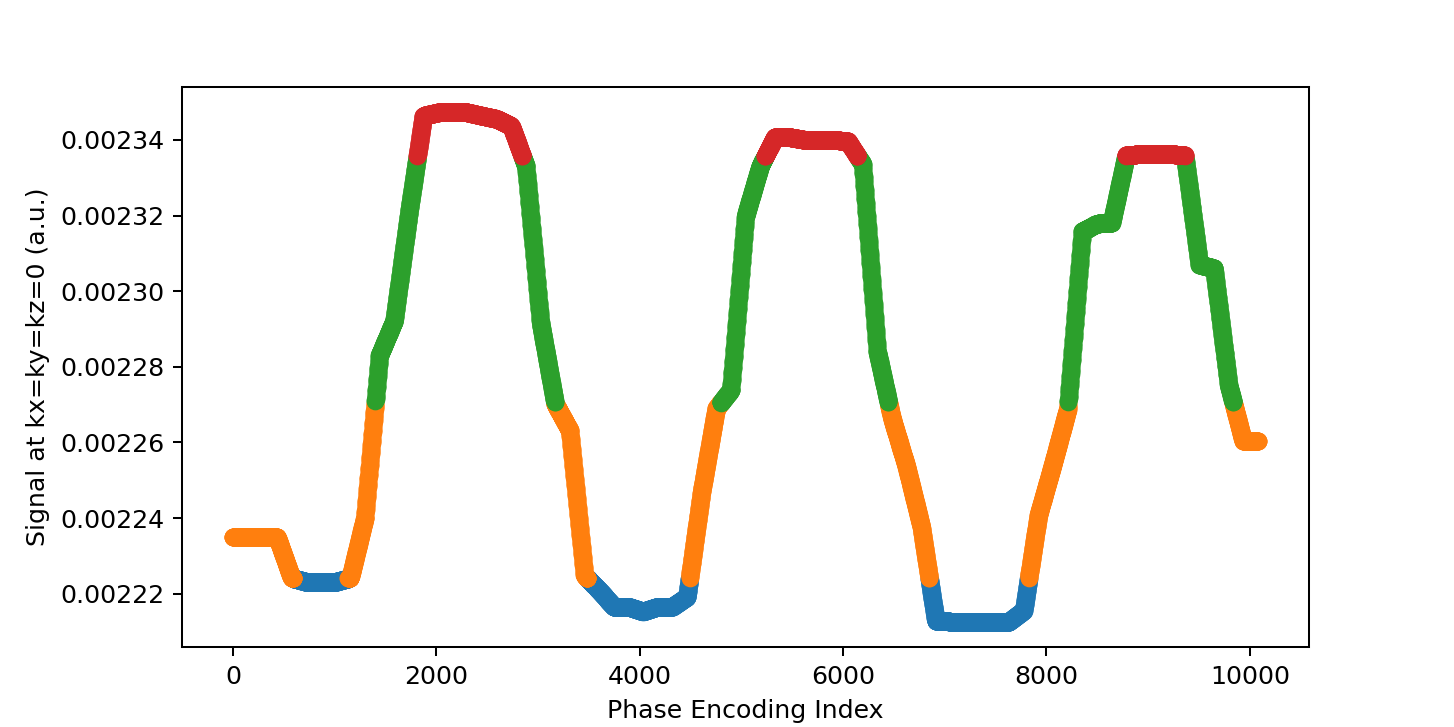

Number of phase encoding points in motion state 0: 2520
Number of phase encoding points in motion state 1: 2520
Number of phase encoding points in motion state 2: 2520
Number of phase encoding points in motion state 3: 2520


In [65]:
# Now let's plot the navigator signal and color in the different motion states in different colors
plt.figure(figsize=(8,4))
plt.plot(self_nav, '-k')
plt.xlabel('Phase encoding index')
plt.ylabel('Signal at kx=ky=kz=0 (a.u.)')
for ind in range(Nms):
    print('Number of phase encoding points in motion state {}: {}'.format(ind, len(acq_idx_ms[ind])))
    plt.plot(acq_idx_ms[ind], self_nav[acq_idx_ms[ind]], 'o')

## Motion Resolved Images
Now we know which phase encoding point has been acquired in which motion state. So we can now create (in our case) 4 different sets of k-space, one for each motion state. Then we can reconstruct these to get an image for each motion state. 

In [68]:
# Go through each motion states, create corresponding k-space and acquisition model
acq_ms = [0] * Nms
E_ms = [0] * Nms


for ind in range(num_ms):
    
    if True:
        acq_ms[ind] = acq_data.new_acquisition_data(empty=True)

        # Add motion resolved data
        for jnd in range(len(acq_idx_ms[ind])):
            cacq = acq_data.acquisition(acq_idx_ms[ind][jnd])
            acq_ms[ind].append_acquisition(cacq)
    else:
        acq_ms[ind] = acq_data.get_subset(acq_idx_ms[ind])
        
    acq_ms[ind].sort_by_time()
        
    # Create acquisition model
    E_tmp = pMR.AcquisitionModel(acqs=acq_ms[ind], imgs=csm)
    E_tmp.set_coil_sensitivity_maps(csm)
    im_ms = E_tmp.inverse(acq_ms[ind])

    E_ms[ind] = pMR.AcquisitionModel(acqs=acq_ms[ind], imgs=im_ms)
    E_ms[ind].set_coil_sensitivity_maps(csm)

Now we can reconstruct each motion state:

In [71]:
im_fista_ms = [0] * num_ms

for ind in range(num_ms):

    # Starting image
    x_init = im_ms.clone()
    x_init.fill(0.0)

    # Objective function
    f = LeastSquares(E_ms[ind], acq_ms[ind], c=1)
    G = ZeroFunction()

    # Set up FISTA for least squares
    fista = FISTA(x_init=x_init, f=f, g=G)
    fista.max_iteration = 100
    fista.update_objective_interval = 5

    # Run FISTA
    fista.run(10, verbose=True)
    
    # Get result
    im_fista_ms[ind] = fista.get_output()
    


FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.36460e-02
        5        100         6.497          6.14886e-04
       10        100         6.355          1.44843e-04
-------------------------------------------------------
       10        100         6.355          1.44843e-04
Stop criterion has been reached.

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          1.54101e-02
        5        100         6.197          1.19455e-03
       10        100         6.228          7.02181e-04
-------------------------------------------------------
       10        100         6.228          7.02181e-04
Stop criterion has been reached.

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            

<IPython.core.display.Javascript object>


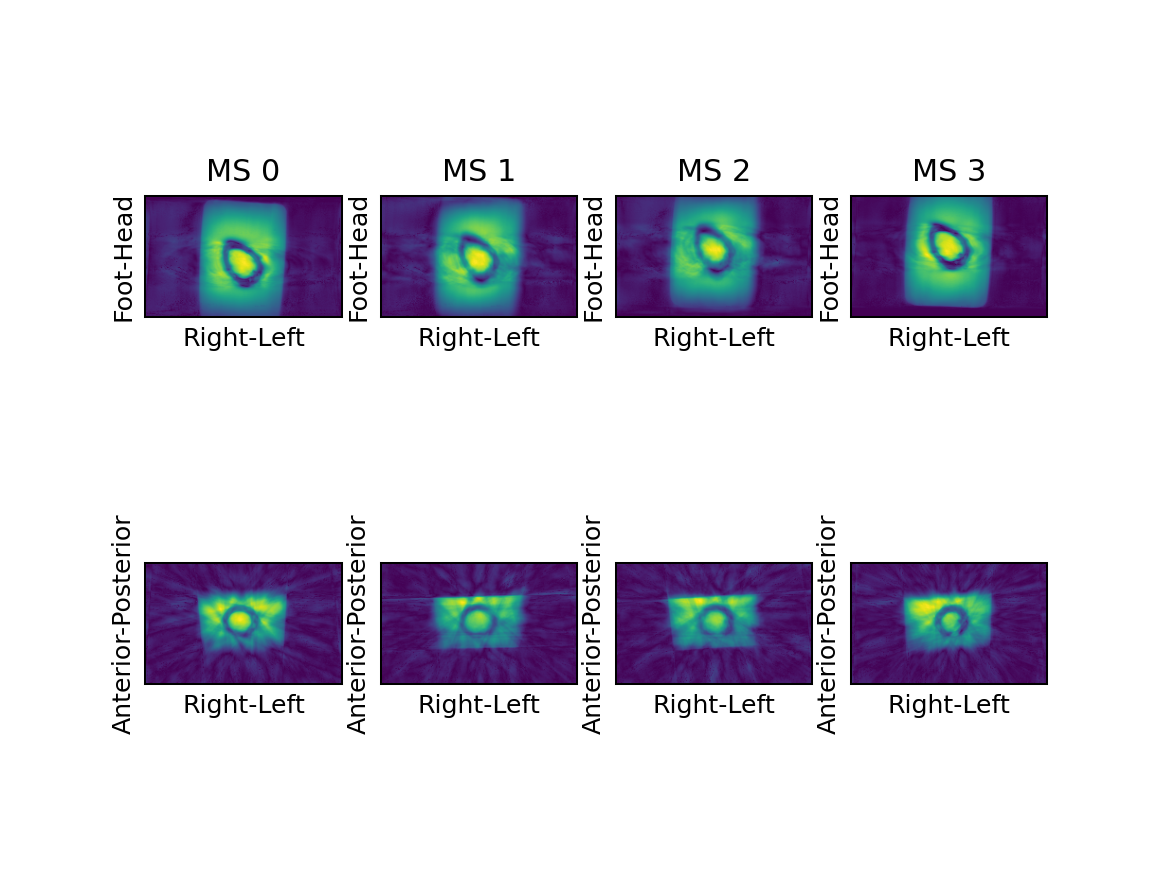

<IPython.core.display.Javascript object>


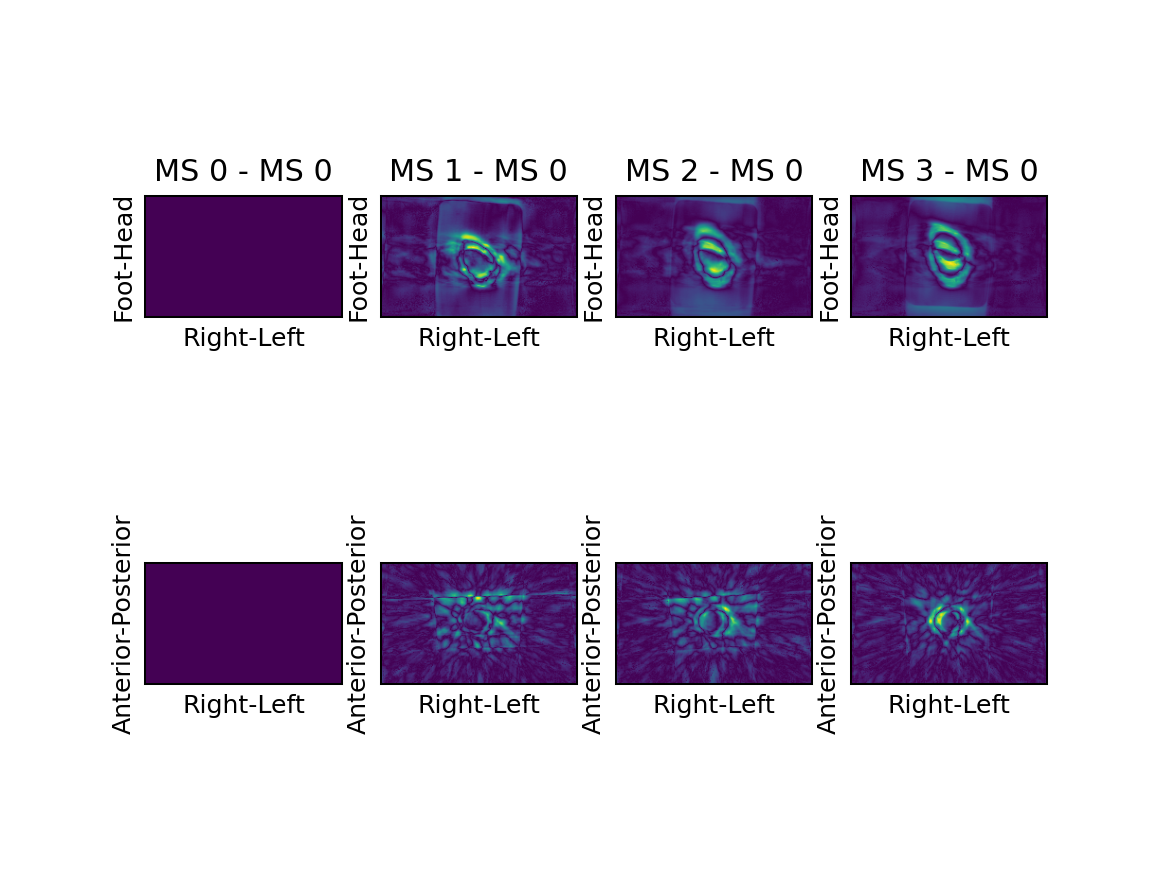

In [72]:
# Prepare results
im_fista_ms_arr = []
im_fista_diff_arr = []
for ind in range(num_ms):
    im_fista_ms_arr.append(im_fista_ms[ind].as_array())
    im_fista_diff_arr.append(np.abs(im_fista_ms[ind].as_array()) - np.abs(im_fista_ms_arr[0]))
    
# Visualise different motion states
plot_rpe_3d(im_fista_ms_arr, [64, 64], ['MS 0', 'MS 1', 'MS 2', 'MS 3'])

# Visualise difference to first motion state
plot_rpe_3d(im_fista_diff_arr, [64, 64], ['MS 0 - MS 0', 'MS 1 - MS 0', 'MS 2 - MS 0', 'MS 3 - MS 0'])

In [17]:
im_ms_rec = []
for ind in range(num_ms):
    im_ms_rec.append(rec_ms_fista[ind].abs())

In [18]:
'''
Register different motion gates
'''

import sirf.Reg as pReg


# Forward motion fields
mf_resampler = [0] * num_ms
im_res = [0] * num_ms
im_corr = [0] * num_ms
for ind in range(num_ms):
    #algo = pReg.NiftyF3dSym()
    algo = pReg.NiftyAladinSym()

    # Set up images
    algo.set_reference_image(pReg.NiftiImageData3D(im_ms_rec[ind])) # remove NiftiImageData3D?????
    algo.set_floating_image(pReg.NiftiImageData3D(im_ms_rec[0]))

    algo.process()
    reg_result = algo.get_output()

    mf_forward = algo.get_deformation_field_forward()


    # Create resampler
    mf_resampler[ind] = pReg.NiftyResample()
    mf_resampler[ind].set_reference_image(rec_ms_fista[ind])
    mf_resampler[ind].set_floating_image(rec_ms_fista[ind])
    mf_resampler[ind].add_transformation(mf_forward)
    mf_resampler[ind].set_padding_value(0)
    mf_resampler[ind].set_interpolation_type_to_linear()

    im_res[ind] = mf_resampler[ind].forward(rec_ms_fista[0])
    im_corr[ind] = mf_resampler[ind].backward(rec_ms_fista[ind])



<IPython.core.display.Javascript object>


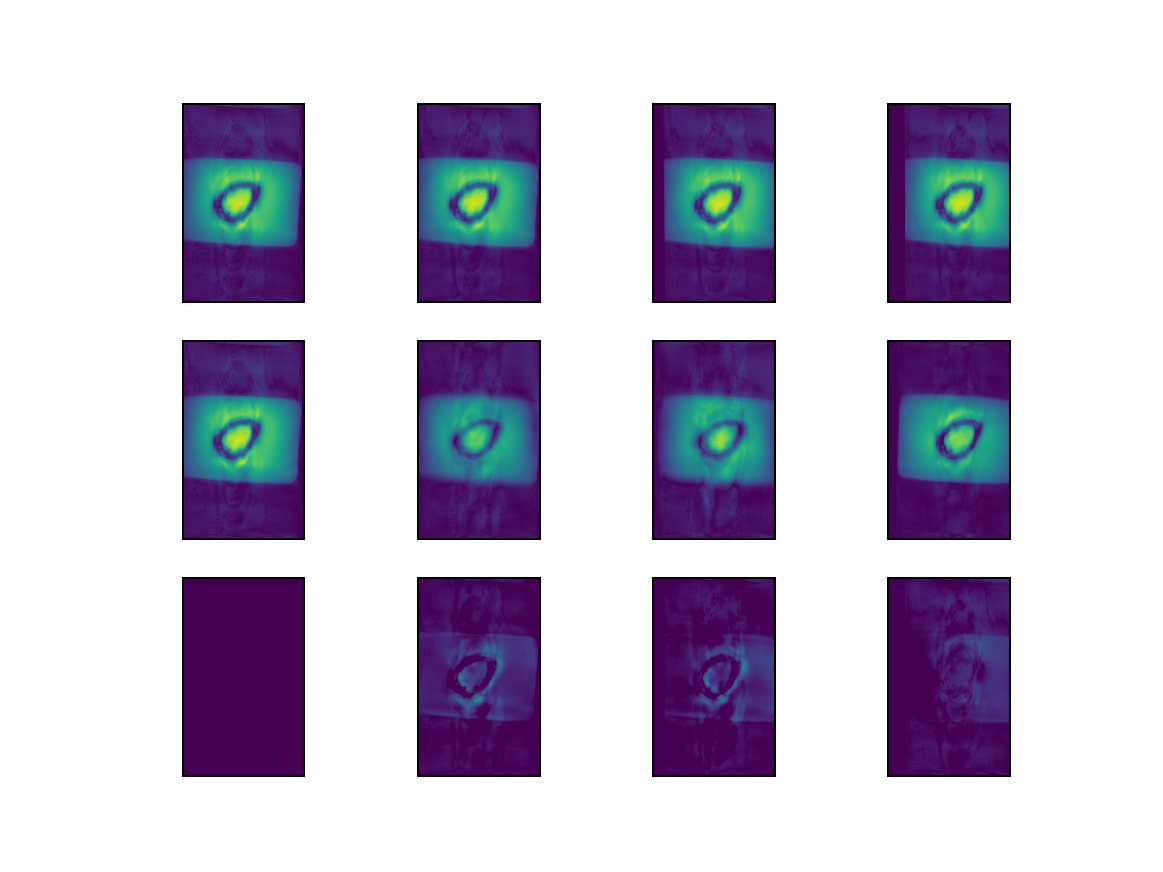

In [19]:


fig, ax = plt.subplots(3, num_ms)
plt.setp(ax, xticks=[], yticks=[])
for ind in range(num_ms):    
    rec_im_arr = im_res[ind].as_array()
    rec_im_arr /= rec_im_arr.max()
    ms_im_arr = im_ms_rec[ind].as_array()
    ms_im_arr /= ms_im_arr.max()
    ax[0, ind].imshow(np.abs(rec_im_arr[:, 64, :]), vmin=0, vmax=1)
    ax[1, ind].imshow(np.abs(ms_im_arr[:, 64, :]), vmin=0, vmax=1)
    ax[2, ind].imshow(np.abs(rec_im_arr[:, 64, :]) - np.abs(ms_im_arr[:, 64, :]), vmin=0, vmax=1)

<IPython.core.display.Javascript object>


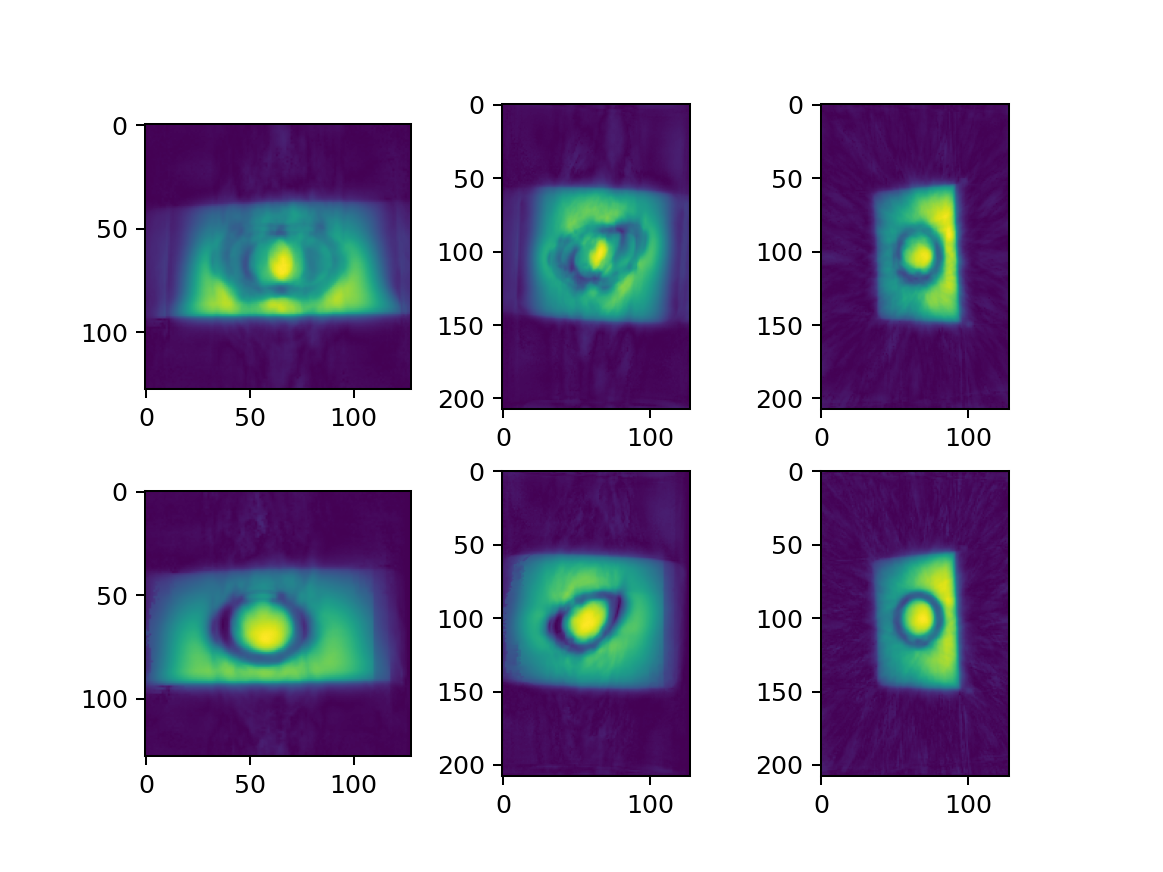

In [20]:
# RTA
im_orig = rec_ms_fista[0]
im_rta = im_corr[0]
for ind in range(1,num_ms):
    im_orig += rec_ms_fista[ind]
    im_rta += im_corr[ind]
    
plot_rpe_3d([im_fista_uncorr, im_orig.as_array(), im_rta.as_array()], [64, 64], ['FISTA uncorr', 'Avg', 'RTA'])

Fix

~/devel/install/python/cil/optimisation/operators/Operator.py in PowerMethod(operator, iterations, x_init)
    145             x1norm = x1.norm()
    146             if hasattr(x0, 'squared_norm'):
--> 147                 s[it] =numpy.abs( x1.dot(x0) / x0.squared_norm())
    148             else:
    149                 x0norm = x0.norm()

TypeError: can't convert complex to float


In [32]:
# Combine AcquisitionModel and motion transformation
C = [CompositionOperator(am, res) for am, res in zip(*(E_ms, mf_resampler))]
A = BlockOperator(*C)

# Put together all the raw k-space data for each motion state in a BlockDataContainer
acq_ms_block = BlockDataContainer(*acq_ms)

# Starting image
x_init = A.adjoint(acq_ms_block)
x_init.fill(0.0)

# Objective function
f = LeastSquares(A, acq_ms_block, c=1)
f.L = 8000.0
G = ZeroFunction()

# Set up FISTA for least squares
fista = FISTA(x_init=x_init, f=f, g=G)
fista.max_iteration = 100
fista.update_objective_interval = 10

# Run FISTA
fista.run(20, verbose=True)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0        100         0.000          5.83088e-02
       10        100        52.506          6.94126e-03
       20        100        52.631          6.37808e-03
-------------------------------------------------------
       20        100        52.631          6.37808e-03
Stop criterion has been reached.



<IPython.core.display.Javascript object>


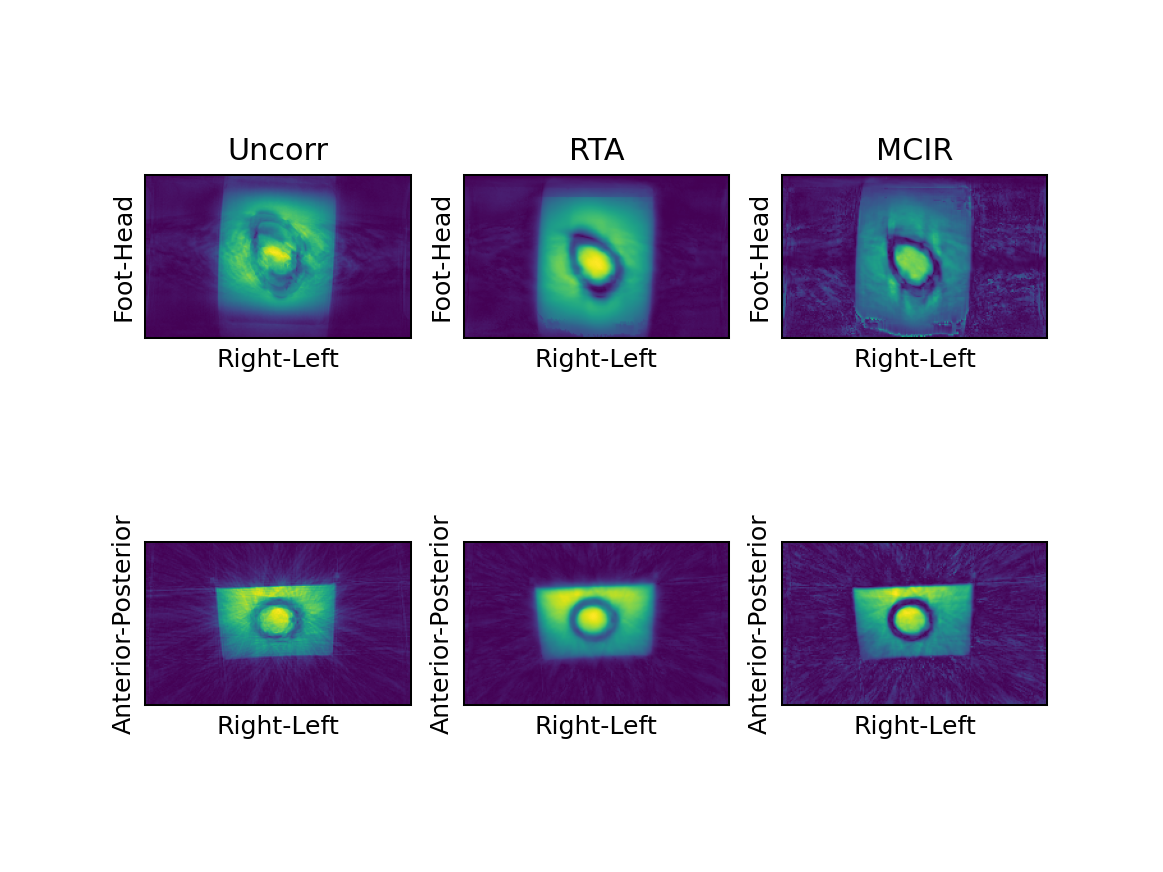

In [33]:
# Get the result
im_fista_mcir = fista.get_output().as_array()

# Compare to the uncorrected reconstruction and the RTA
plot_rpe_3d([im_fista_uncorr, im_rta.as_array(), im_fista_mcir], [64, 64], ['Uncorr', 'RTA', 'MCIR'])